# Lead-Lag Pairs Trading

In [1]:
import notebook_base

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import signatory
import statsmodels.api as sm

from mean_variance.utils import *
from mean_variance.simulators import *
from mean_variance.sig_trader import *
from mean_variance.sig_factor_model import *
from data.path import Path

In [2]:
# cmap = ListedColormap([sns.color_palette("Blues")[5], 'mediumseagreen', "orange" , "lightskyblue" ])
# plt.rcParams["axes.prop_cycle"] = plt.cycler("color", cmap.colors)

### Create Data

In [3]:
batch_length = 20

sample_size = 1000000
rho = 0.01
sigma_x = 0.02
sigma_y = 0.015
kappa = 0.3
cov_mat=torch.tensor([[sigma_x**2, rho*sigma_x*sigma_y],[rho*sigma_x*sigma_y, sigma_y**2]])
mu_vec = torch.tensor([[0.00],[0.00]]) # no drift
dim = mu_vec.shape[0]

In [4]:
choleskyMatrix = torch.linalg.cholesky(cov_mat)
e = torch.normal(0, 1, size=(sample_size, batch_length, dim))
noise = torch.matmul(e,choleskyMatrix)

In [5]:
paths = torch.ones(noise.shape)

for t in range(1,batch_length):
    paths[:,t,0] = paths[:,t-1,0] + noise[:,t,0]
    paths[:,t,1] = paths[:,t-1,1] + kappa*(paths[:,t,0] - paths[:,t-1,1]) + noise[:,t,1]

train_paths = paths[:int(sample_size*0.8)]
test_paths = paths[int(sample_size*0.8):]

### Fit Sig Trader

In [6]:
order = 3
ST = SigTrader(order=order)
ST.fit(asset_paths = train_paths)

In [7]:
position, pnl = ST.compute_pnl(asset_paths = test_paths, order=order)

### Creating a Sig Factor Model

In [8]:
SFM = SigFactorModel(ST)

In [9]:
l_SFM = SFM.fit()

In [10]:
SFM_pos, SFM_pnl = SFM.compute_pnl(asset_paths = test_paths)

### Fitting multiple models

In [13]:
all_ST_pos = []
all_ST_pnl = []
all_ST_sharpes = []

all_FM_pos = []
all_FM_pnl = []
all_FM_sharpes = []

for order in range(1,4):

    ST = SigTrader(order=order)
    ST.fit(asset_paths = train_paths)
    position, pnl = ST.compute_pnl(asset_paths = test_paths, order=order)
    
    SFM = SigFactorModel(ST)
    l_SFM = SFM.fit()
    SFM_pos, SFM_pnl = SFM.compute_pnl(asset_paths = test_paths)

    SFM_sharpes = SFM_pnl.diff(dim=1).mean(dim=1)/SFM_pnl.diff(dim=1).std(dim=1)
    ST_sharpes = pnl.diff(dim=1).mean(dim=1)/pnl.diff(dim=1).std(dim=1)

    all_ST_pos.append(position)
    all_ST_pnl.append(pnl)
    all_ST_sharpes.append(ST_sharpes)

    all_FM_pos.append(SFM_pos)
    all_FM_pnl.append(SFM_pnl)
    all_FM_sharpes.append(SFM_sharpes)

all_ST_pos = torch.stack(all_ST_pos, dim=0)
all_ST_pnl = torch.stack(all_ST_pnl, dim=0)
all_ST_sharpes = torch.stack(all_ST_sharpes, dim=0)
all_FM_pos = torch.stack(all_FM_pos, dim=0)
all_FM_pnl = torch.stack(all_FM_pnl, dim=0)
all_FM_sharpes = torch.stack(all_FM_sharpes, dim=0)

### Plotting

In [14]:
pos_scale=1/1.5
alloc_scale = 1/6

z1 = np.polyfit(all_FM_pos[0,:,-1,1],all_ST_pos[0,:,-1,1], 1)
p1 = np.poly1d(z1)

z2 = np.polyfit(all_FM_pos[1,:,-1,1],all_ST_pos[1,:,-1,1], 2)
p2 = np.poly1d(z2)

z3 = np.polyfit(all_FM_pos[2,:,-1,1],all_ST_pos[2,:,-1,1], 3)
# z3 = np.polyfit(x3[0],x3[1], 3)
p3 = np.poly1d(z3)

x = np.linspace((all_FM_pos[0,:,-1,1]).min(),(all_FM_pos[0,:,-1,1]).max(),100)

(-9.9, 9.9)

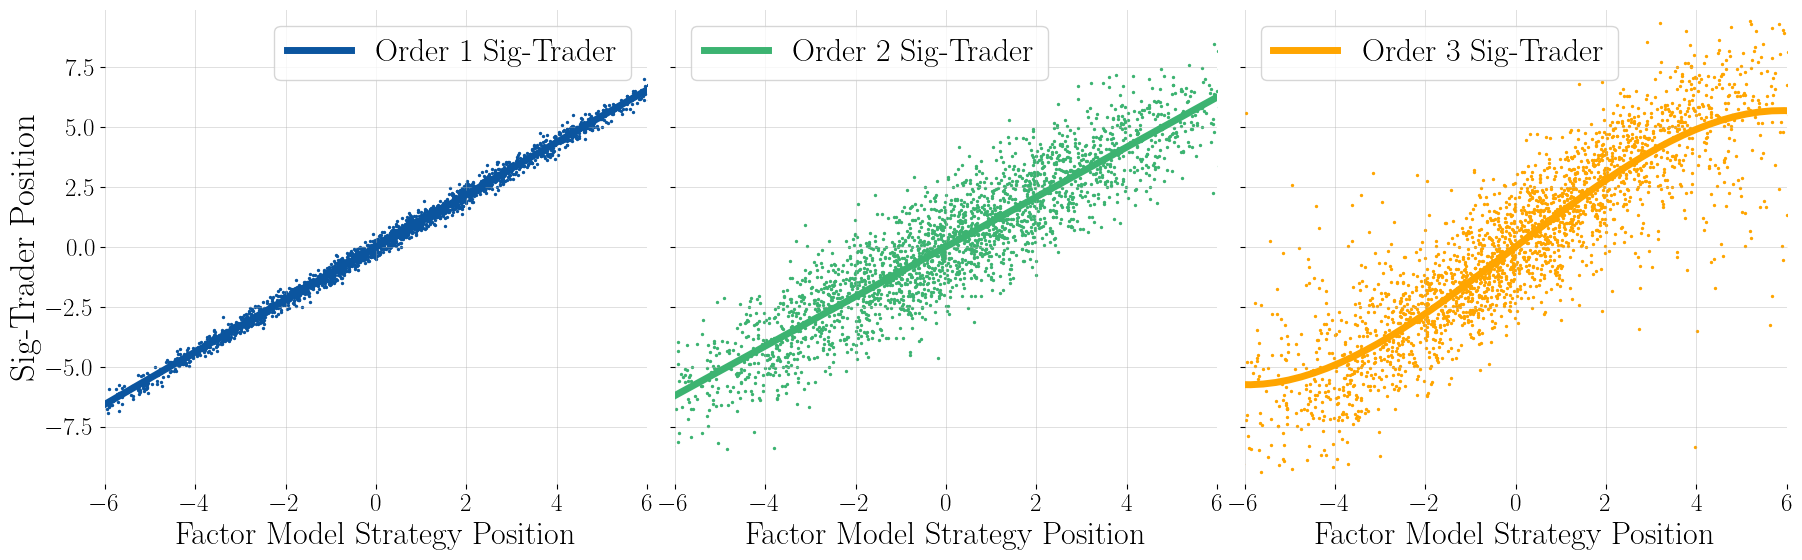

In [15]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap([sns.color_palette("Blues")[5], 'mediumseagreen', "orange" , "lightskyblue" ])

num_scatter = 2500

fig, ax = plt.subplots(1,3,figsize=(18,5.7), sharey=True, sharex=True)

ax[0].scatter(all_FM_pos[0,:num_scatter,-1,1].flatten(),all_ST_pos[0,:num_scatter,-1,1].flatten(), color=cmap.colors[0],s=2)
ax[1].scatter(all_FM_pos[1,:num_scatter,-1,1].flatten(),all_ST_pos[1,:num_scatter,-1,1].flatten(), color=cmap.colors[1],s=2)
ax[2].scatter(all_FM_pos[2,:num_scatter,-1,1].flatten(),all_ST_pos[2,:num_scatter,-1,1].flatten(), color=cmap.colors[2],alpha=1,s=2)

ax[0].plot(x,p1(x), color=cmap.colors[0], lw=5, label = "Order 1 Sig-Trader");
ax[1].plot(x,p2(x), color=cmap.colors[1], lw=5, label = "Order 2 Sig-Trader");
ax[2].plot(x,p3(x), color=cmap.colors[2], lw=5, label = "Order 3 Sig-Trader");

ax[0].set_ylabel('Sig-Trader Position', fontsize=23)

for i in range(3):
    ax[i].tick_params(axis='y', labelsize=18)
    # ax[i].set_title(' ', fontsize=25)
    ax[i].yaxis.label.set_size(25)
    ax[i].xaxis.label.set_size(25)
    right_side = ax[i].spines["right"]
    right_side.set_visible(False)
    top_side = ax[i].spines["top"]
    top_side.set_visible(False)
    left_side = ax[i].spines["left"]
    left_side.set_visible(False)
    bottom_side = ax[i].spines["bottom"]
    bottom_side.set_visible(False)
    ax[i].tick_params(axis='x', labelsize=18)
    ax[i].tick_params(axis='y', labelsize=18)
    # vals = axis[i].get_yticks()
    # axis[i].set_yticklabels(['{:.0%}'.format(x) for x in vals])
    ax[i].grid(alpha=0.4, linewidth=.7)
    ax[i].legend(loc='best',fontsize=23)
    ax[i].set_xlabel('Factor Model Strategy Position', fontsize=23)

# plt.subplots_adjust(wspace=0.1)
fig.tight_layout(w_pad=2)
plt.xlim(-6,6)
plt.ylim(-9.9,9.9)

In [27]:
FM_means = np.array(all_FM_pnl[:,:,-1].mean(dim=1))
FM_vars = np.array(all_FM_pnl[:,:,-1].std(dim=1)**2)
ST_means = np.array(all_ST_pnl[:,:,-1].mean(dim=1))
ST_vars = np.array(all_ST_pnl[:,:,-1].std(dim=1)**2)

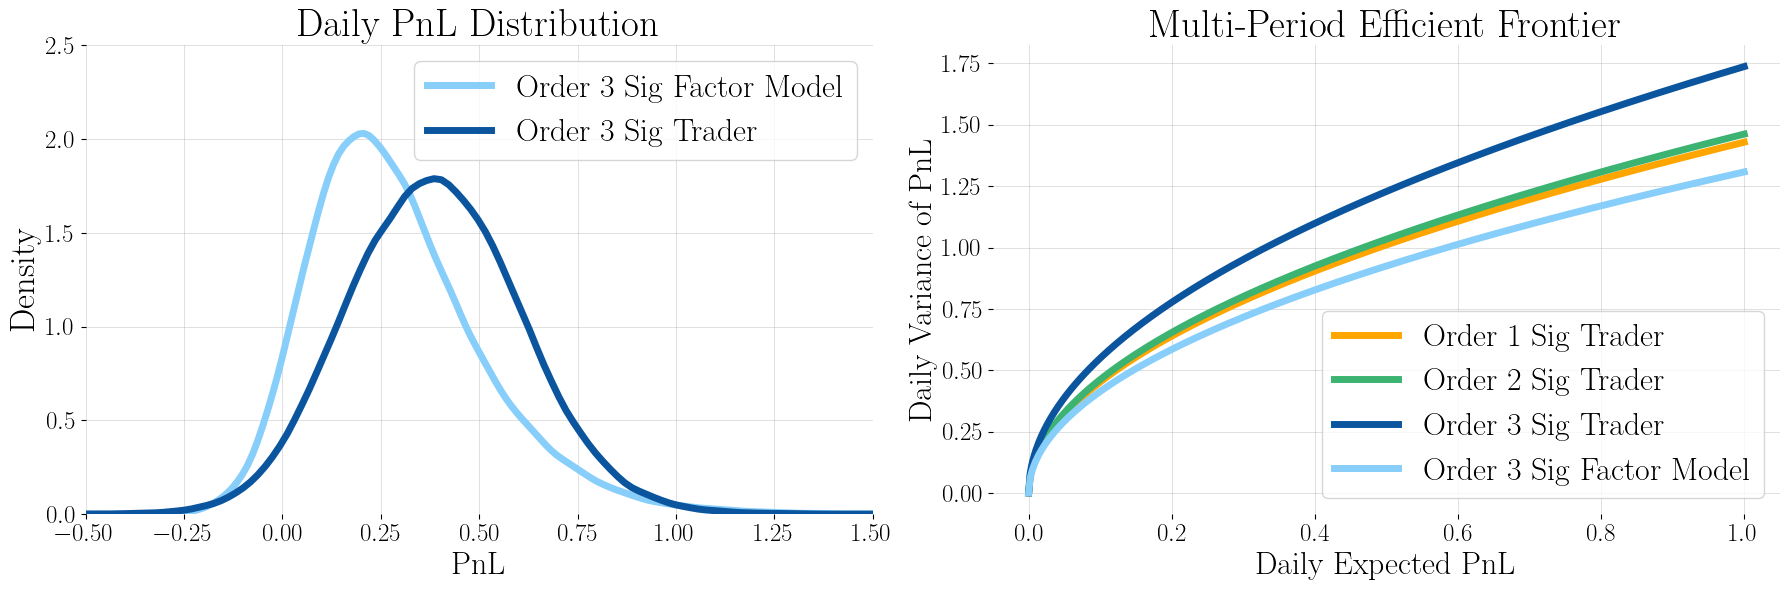

In [37]:
fig, ax = plt.subplots(1,2,figsize=(18,6))

sns.kdeplot(all_FM_pnl[-1,:,-1].flatten(), label='Order 3 Sig Factor Model', color=cmap.colors[-1], ax=ax[0], lw=5, bw_adjust=1.1)
sns.kdeplot(all_ST_pnl[-1,:,-1], label='Order 3 Sig Trader', ax=ax[0], lw=5, bw_adjust=1.1)
ax[0].legend(fontsize=13)
ax[0].set_xlim(-0.5,1.5)
ax[0].set_ylim(0,2.5)

x_lim = 1
for i in range(len(all_ST_pnl)):
    ax[1].plot(np.linspace(0,x_lim,500), np.sqrt(np.linspace(0,x_lim,500))*(ST_means[i])/np.sqrt(ST_vars[i]),lw=5,color=cmap.colors[2-i], label='Order '+str(i+1)+' Sig Trader')
ax[1].plot(np.linspace(0,x_lim,500), np.sqrt(np.linspace(0,x_lim,500))*(FM_means[i])/np.sqrt(FM_vars[i]),lw=5,color=cmap.colors[3], label='Order 3 Sig Factor Model')
ax[1].legend(fontsize=13)

for i in range(2):
    ax[i].tick_params(axis='y', labelsize=18)
    # ax[i].set_title(' ', fontsize=25)
    ax[i].yaxis.label.set_size(25)
    ax[i].xaxis.label.set_size(25)
    right_side = ax[i].spines["right"]
    right_side.set_visible(False)
    top_side = ax[i].spines["top"]
    top_side.set_visible(False)
    left_side = ax[i].spines["left"]
    left_side.set_visible(False)
    bottom_side = ax[i].spines["bottom"]
    bottom_side.set_visible(False)
    ax[i].tick_params(axis='x', labelsize=18)
    ax[i].tick_params(axis='y', labelsize=18)
    # vals = axis[i].get_yticks()
    # axis[i].set_yticklabels(['{:.0%}'.format(x) for x in vals])
    ax[i].grid(alpha=0.4, linewidth=.7)
    ax[i].legend(loc='best',fontsize=23)

ax[0].set_xlabel('PnL', fontsize=23)
ax[1].set_xlabel('Daily Expected PnL', fontsize=23)
ax[1].set_ylabel('Daily Variance of PnL', fontsize=23)
ax[0].set_title('Daily PnL Distribution', fontsize=28)
ax[1].set_title('Multi-Period Efficient Frontier', fontsize=28)

fig.tight_layout()